参见第七篇论文，输入时间粒度为5min，输出时间粒度为15min

In [1]:
%config InlineBackend.figure_format = 'retina'

from utils.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers import Dense, LSTM, Input, Concatenate
from keras.models import Model

Using TensorFlow backend.


In [2]:
ts = get_flow_series_by_idx(0)
scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1, 1))  # z-score normalize

timesteps = 21
predict_horizon = 3
wsize = timesteps + predict_horizon  # window size


def getXY(arr, timesteps=12, predict_horizon=1):
    if isinstance(arr, np.ndarray):
        arr = arr.tolist()
    Xo = []  # near-term traffic flow
    Xd = []  # traffic flow of last day
    Xw = []  # traffic flow of last week
    Y = []  # predicted traffic flow
    wsize = timesteps + predict_horizon  # window size
    for i in range(0, len(arr)-12*24*7-wsize+1, predict_horizon):
        Xw.append(arr[i:(i+wsize)])
        Xd.append(arr[(i+12*24*6):(i+12*24*6+wsize)])
        Xo.append(arr[(i+12*24*7):(i+12*24*7+timesteps)])
        Y.append(arr[(i+12*24*7+timesteps):(i+12*24*7+wsize)])
    Xo = np.array(Xo).reshape(-1, timesteps, 1)
    Xd = np.array(Xd).reshape(-1, wsize, 1)
    Xw = np.array(Xw).reshape(-1, wsize, 1)
    Y = np.array(Y).reshape(-1, predict_horizon, 1).sum(axis=-2)
    return Xo, Xd, Xw, Y

XY = getXY(arr, timesteps, predict_horizon)
test_size = 4*24*7
trainXY = [x[:-test_size] for x in XY]
testXY = [x[-test_size:] for x in XY]

In [3]:
inputO = Input(shape=(timesteps,1))  # near-term traffic flow INPUT
inputD = Input(shape=(wsize,1))  # traffic flow of last day INPUT
inputW = Input(shape=(wsize,1))  # traffic flow of last week INPUT

rnnO = LSTM(128, activation='relu')(inputO)
rnnD = LSTM(128, activation='relu')(inputD)
rnnW = LSTM(128, activation='relu')(inputW)

hiddenO = Dense(64, activation='relu')(rnnO)
hiddenD = Dense(64, activation='relu')(rnnD)
hiddenW = Dense(64, activation='relu')(rnnW)

outputO = Dense(1)(hiddenO)
outputD = Dense(1)(hiddenD)
outputW = Dense(1)(hiddenW)

modelO = Model(inputs=inputO, outputs=outputO)
modelD = Model(inputs=inputD, outputs=outputD)
modelW = Model(inputs=inputW, outputs=outputW)

output = Concatenate()([outputO, outputD, outputW])
output = Dense(1)(output)

model = Model(inputs=[inputO, inputD, inputW], outputs=output)

In [4]:
# pre-train
modelO.compile(optimizer='rmsprop', loss='mse')
modelD.compile(optimizer='rmsprop', loss='mse')
modelW.compile(optimizer='rmsprop', loss='mse')

modelO.fit(x=trainXY[0], y=trainXY[-1], epochs=128, batch_size=256, verbose=0)
modelD.fit(x=trainXY[1], y=trainXY[-1], epochs=128, batch_size=256, verbose=0)
modelW.fit(x=trainXY[2], y=trainXY[-1], epochs=128, batch_size=256, verbose=0)

In [5]:
# train
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=trainXY[0:-1], y=trainXY[-1], epochs=128, batch_size=256, validation_split=0.1, verbose=0)

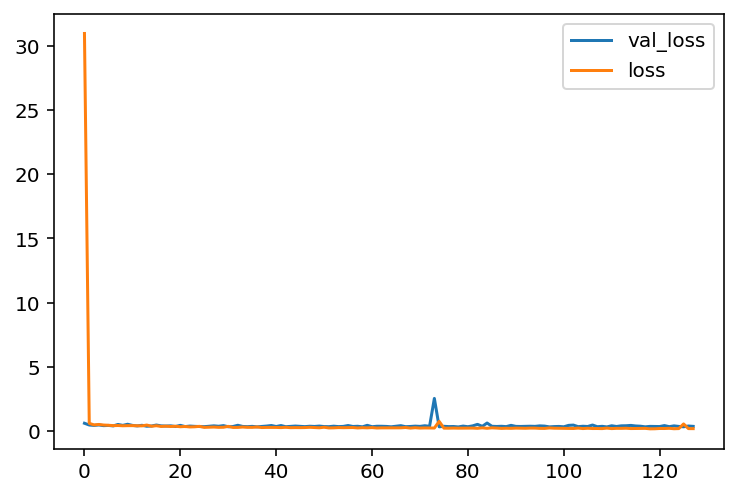

In [6]:
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.legend()

{'mae': 13.42142671579322,
 'rmse': 18.86149429669151,
 'mape': 14.725722036978842}

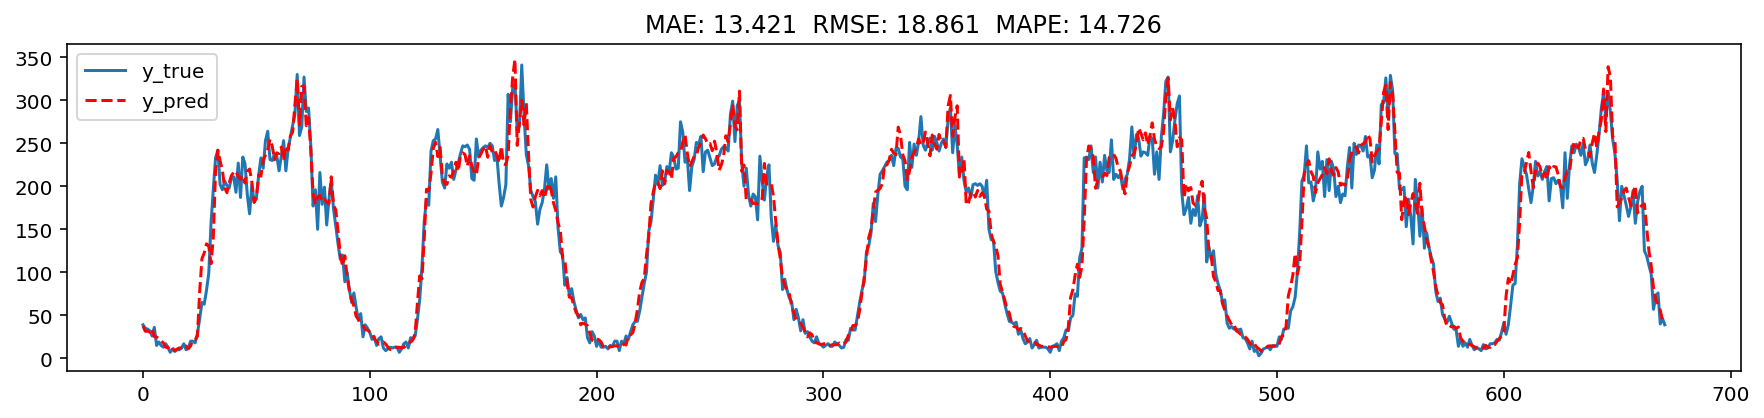

In [7]:
testX = testXY[0:-1]
testY = testXY[-1] * scaler.var_**.5 + predict_horizon * scaler.mean_
y_pred = model.predict(testX)
y_pred = y_pred * scaler.var_**.5 + predict_horizon * scaler.mean_

test_y_pred(testY, y_pred, plot_with_figsize=(15,3))